In [1]:
import uproot
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
from sklearn.model_selection import cross_val_score, cross_val_predict, train_test_split
from collections import namedtuple, defaultdict
import open3d as o3d
import random
random.seed(42)
import h5py
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import joblib

In [2]:
hf_pair_indices_ev1= h5py.File("./true_pair_index_ev1.hdf5", 'r')
hf_nopair_indices_ev1 = h5py.File("./false_pair_index_ev1.hdf5", 'r')
hf_cellFeatures_ev1 = h5py.File("./cellFeatures_ev1.hdf5", 'r')
hf_sharedCellsIndices = h5py.File("./sharedCellsIndices.hdf5", 'r')

In [3]:
true_pair_ev1 = hf_pair_indices_ev1.get('true_pair')[:]
false_pair_ev1 = hf_nopair_indices_ev1.get('false_pair')[:]
cellFeatures_ev1 = hf_cellFeatures_ev1.get('cellFeatures')[:]

In [4]:
hf_pair_indices_ev1.close()
hf_nopair_indices_ev1.close()
hf_cellFeatures_ev1.close()

In [5]:
print("true_pair_ev1.shape: ",true_pair_ev1.shape)
print("false_pair_ev1.shape: ",false_pair_ev1.shape)
print("cellFeatures_ev1.shape: ",cellFeatures_ev1.shape)

true_pair_ev1.shape:  (2199950, 2)
false_pair_ev1.shape:  (450580, 2)
cellFeatures_ev1.shape:  (187652, 8)


In [7]:
false_pair_ev1_400k = false_pair_ev1[:400000] # using 500k nopais
true_pair_ev1_400k = true_pair_ev1[:400000]          # using 500k pais

In [8]:
print("pair_500k.shape: ",true_pair_ev1_400k.shape)
print("nopair_500k.shape: ",false_pair_ev1_400k.shape)

pair_500k.shape:  (400000, 2)
nopair_500k.shape:  (400000, 2)


In [9]:
total_indices_ev1 = np.concatenate((true_pair_ev1_400k,false_pair_ev1_400k),axis=0)

In [10]:
total_indices_ev1.shape

(800000, 2)

In [14]:
total_label_ev1 = np.concatenate(([1]*400000,[-1]*400000),axis=0)

In [12]:
scaler = joblib.load('./scaler.save')
cellFeatures_ev1S = scaler.transform(cellFeatures_ev1)

In [13]:
pair_features_ev1 = []
for pair in total_indices_ev1:
    pair_features_ev1.append((cellFeatures_ev1S[pair[0]],\
                        cellFeatures_ev1S[pair[1]]))

In [15]:
# Convert data to PyTorch tensors
ev1Pairs = [(torch.Tensor(pair[0]), torch.Tensor(pair[1])) for pair in pair_features_ev1]
ev1Labels = torch.tensor(total_label_ev1, dtype=torch.float32)

In [16]:
# Custom dataset for pairwise training
class SiameseDataset(Dataset):
    def __init__(self, data, labels, transform=None):
        self.data = data
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        pair = (self.data[index][0], self.data[index][1])
        label = torch.tensor(self.labels[index], dtype=torch.float32)

        if self.transform:
            pair = (self.transform(pair[0]), self.transform(pair[1]))

        return pair, label

In [17]:
ev1Dataset = SiameseDataset(data=ev1Pairs, labels=ev1Labels)
ev1Dataloader = DataLoader(ev1Dataset, batch_size=800000, shuffle=False)

In [18]:
# Distance of test sample before training
ev1Dist = []
ev1Label = []
for batch in ev1Dataloader:
        inputs, target = batch
        input1, input2 = inputs

        # Forward pass
        distances = torch.pairwise_distance(input1, input2)
        ev1Dist.append(distances)
        ev1Label.append(target)

/var/folders/k8/cklb1sxj1p35mft4gbkymsc091k_dc/T/ipykernel_97223/1935613023.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(self.labels[index], dtype=torch.float32)


In [19]:
distArray_b4_ev1 = ev1Dist[0].detach().numpy()
labelArray_b4_ev1 = ev1Label[0].detach().numpy()

In [20]:
simCells_b4_ev1 = [i for i in range(len(labelArray_b4_ev1)) if labelArray_b4_ev1[i]==1]
asimCells_b4_ev1 = [i for i in range(len(labelArray_b4_ev1)) if labelArray_b4_ev1[i]==-1]
simArray_b4_ev1 = distArray_b4_ev1[simCells_b4_ev1]
asimArray_b4_ev1 = distArray_b4_ev1[asimCells_b4_ev1]

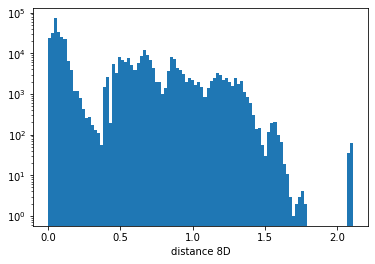

In [22]:
plt.hist(simArray_b4_ev1, bins = 100)
plt.yscale("log")
plt.xlabel("distance 8D")
plt.show()

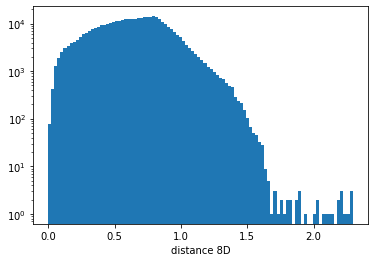

In [23]:
plt.hist(asimArray_b4_ev1, bins=100)
plt.yscale("log")
plt.xlabel("distance 8D")
plt.show()

In [24]:
class SiameseNetwork(nn.Module):
    def __init__(self, input_size):
        super(SiameseNetwork, self).__init__()

        # Define the architecture for one branch of the Siamese network
        self.branch = nn.Sequential(
            nn.Linear(input_size, 128),
            #nn.BatchNorm1d(128),
            nn.ReLU(inplace=True),
            nn.Linear(128, 128),
            #nn.BatchNorm1d(128),
            nn.ReLU(inplace=True),
            nn.Linear(128, 128),
            #nn.BatchNorm1d(128),
            nn.ReLU(inplace=True),
            nn.Linear(128, 64),
            #nn.BatchNorm1d(64),
            nn.ReLU(inplace=True),
            nn.Linear(64, 32),
            #nn.BatchNorm1d(32),
            nn.ReLU(inplace=True),
            nn.Linear(32, 16),
        )

    def forward_one(self, x):
        # Forward pass for one branch of the Siamese network
        return self.branch(x)

    def forward(self, input1, input2):
        # Forward pass for both branches of the Siamese network
        output1 = self.forward_one(input1)
        output2 = self.forward_one(input2)
        return output1, output2

In [25]:
input_size = 8
path = "/Users/bakshiguptad/ML/MLBasedCaloClusteringPipeLine/siamese_net.pth"
model = SiameseNetwork(input_size)
#model.load(torch.load(path))
model = torch.load(path)

In [26]:
dist_ev1 = []
label_ev1 = []
for batch in ev1Dataloader:
        inputs, target = batch
        input1, input2 = inputs

        # Forward pass
        output1, output2 = model(input1, input2)
        distances = torch.pairwise_distance(output1, output2)
        dist_ev1.append(distances)
        label_ev1.append(target)

/var/folders/k8/cklb1sxj1p35mft4gbkymsc091k_dc/T/ipykernel_97223/1935613023.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(self.labels[index], dtype=torch.float32)


In [27]:
distArray_ev1 = dist_ev1[0].detach().numpy()
labelArray_ev1 = label_ev1[0].detach().numpy()

In [28]:
simArray_ev1 = distArray_ev1[simCells_b4_ev1]
asimArray_ev1 = distArray_ev1[asimCells_b4_ev1]

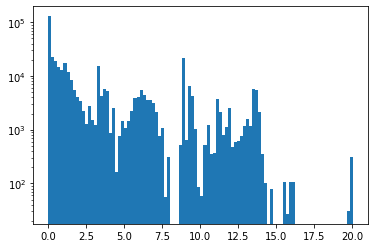

In [29]:
plt.hist(simArray_ev1, bins=100)
plt.yscale("log")
#plt.xlim(0,0.1)
plt.show()

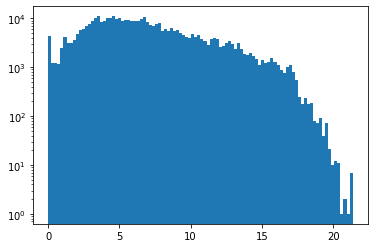

In [30]:
plt.hist(asimArray_ev1, bins=100)
plt.yscale("log")
#plt.xlim(0,0.1)
plt.show()

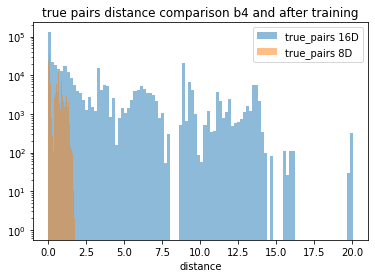

In [31]:
plt.hist(simArray_ev1,  
         alpha=0.5, # the transaparency parameter 
         label='true_pairs 16D',bins=100) 
  
plt.hist(simArray_b4_ev1, 
         alpha=0.5, 
         label='true_pairs 8D',bins=100) 
  
plt.legend(loc='upper right') 
plt.yscale("log")
plt.xlabel("distance")
plt.title('true pairs distance comparison b4 and after training') 
plt.show()

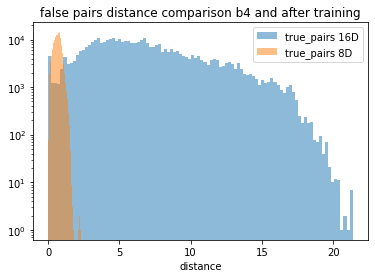

In [32]:
plt.hist(asimArray_ev1,  
         alpha=0.5, # the transaparency parameter 
         label='true_pairs 16D',bins=100) 
  
plt.hist(asimArray_b4_ev1, 
         alpha=0.5, 
         label='true_pairs 8D',bins=100) 
  
plt.legend(loc='upper right') 
plt.yscale("log")
plt.xlabel("distance")
plt.title('false pairs distance comparison b4 and after training') 
plt.show()